In [1]:
import jax.numpy as jnp
from jax import random, grad
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import Linear

### 1D case

In [2]:
key = random.PRNGKey(0)

def func(x,noise=0.0):
    return 0.5*x + noise*random.normal(key,x.shape)

def grad_func(x,noise=0.0):
    return 0.5 + noise*random.normal(key,x.shape)

In [3]:
bounds = jnp.array([0.0, 1.0])

noise = 0.1

offset = noise**2

num_datapoints = 1
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (5,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 9
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = Linear(offset)

In [4]:
model = gpr.GPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ppa",noise_var=noise**2)
model.fit(X_data,Y_data)
(means_ppa, stds_ppa) = model.predict(grid.reshape(-1,1),True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

# model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="sor",noise_var=noise**2)
# model.fit(X_data,Y_data)
# (means_sor, stds_sor) = model.predict(grid.reshape(-1,1),True)
# means_sor = means_sor.reshape(-1)
# stds_sor = stds_sor.reshape(-1)

# model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ny",noise_var=noise**2)
# model.fit(X_data,Y_data)
# (means_ny, stds_ny) = model.predict(grid.reshape(-1,1),True)
# means_ny = means_ny.reshape(-1)
# stds_ny = stds_ny.reshape(-1)

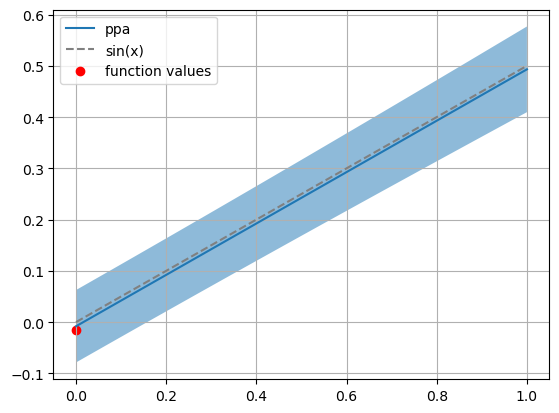

In [5]:
plt.plot(grid,means_ppa,label="ppa")
plt.fill_between(grid,means_ppa-stds_ppa,means_ppa+stds_ppa,alpha=0.5)
# plt.plot(grid,means_sor,label="sor")
# plt.fill_between(grid,means_sor-stds_sor,means_sor+stds_sor,alpha=0.5)
# plt.plot(grid,means_ny,label="ny")
# plt.fill_between(grid,means_ny-stds_ny,means_ny+stds_ny,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

## 2D case

In [6]:
key = random.PRNGKey(0)

def func(x1, x2,noise=0.0):
    return 0.5*x1 + 0.3*x2 + noise*random.normal(key, x1.shape)

def dx1_func(x1, x2, noise=0.0):
    return 0.5 + noise*random.normal(key, x1.shape)

def dx2_func(x1, x2, noise=0.0):
    return 0.3 + noise*random.normal(key, x1.shape)

In [7]:
bounds = jnp.array([[0.0, 1.0], [0.0, 1.0]])

noise = 0.1

offset = noise**2

n_data_points = jnp.array([3, 3])
n_X1_deriv_points = jnp.array([10, 10])
n_X2_deriv_points = jnp.array([10, 10])

n_ref_points = jnp.array([10,10])

n_grid_points = jnp.array([101,101])

kernel = Linear(offset)

In [8]:
# all the 1d grids for the according to the n_..._points above
data_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_data_points)]
X1_deriv_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_X1_deriv_points)]
X2_deriv_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_X2_deriv_points)]
ref_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_ref_points)]

grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_grid_points)]

# all 2d grids
data_grid = jnp.array(jnp.meshgrid(*data_grids)).reshape(2,-1).T
dX1_grid = jnp.array(jnp.meshgrid(*X1_deriv_grids)).reshape(2,-1).T
dX2_grid = jnp.array(jnp.meshgrid(*X2_deriv_grids)).reshape(2,-1).T

#all function values
data_values = func(data_grid[:,0], data_grid[:,1], noise)
dX1_values = dx1_func(dX1_grid[:,0], dX1_grid[:,1], noise)
dX2_values = dx2_func(dX2_grid[:,0], dX2_grid[:,1], noise)

# final data used for prediction
X_data = jnp.concatenate((data_grid, dX1_grid, dX2_grid))
Y_data = jnp.concatenate((data_values, dX1_values, dX2_values))

# reference grid for fitting and predicting
referencegrid = jnp.array(jnp.meshgrid(*ref_grids)).reshape(2,-1).T
# grid on which the means and stds will be predicted
grid = jnp.array(jnp.meshgrid(*grids)).reshape(2,-1).T

# total lengths of the necessary data
total_data_points = jnp.prod(n_data_points)
total_deriv_points = (jnp.prod(n_X1_deriv_points), jnp.prod(n_X2_deriv_points))
total_ref_points = jnp.prod(n_ref_points)
total_grid_points = jnp.prod(n_grid_points)

In [9]:
model = gpr.GPR(kernel, total_data_points, total_deriv_points, referencegrid, sparse_method="ppa", noise_var=noise**2)
model.fit(X_data, Y_data)
(means_ppa, stds_ppa) = model.predict(grid, True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

# model = gpr.sparseGPR(kernel, total_data_points, total_deriv_points, referencegrid, sparse_method="sor", noise_var=noise**2)
# model.fit(X_data, Y_data)
# (means_sor, stds_sor) = model.predict(grid, True)
# means_sor = means_sor.reshape(-1)
# stds_sor = stds_sor.reshape(-1)

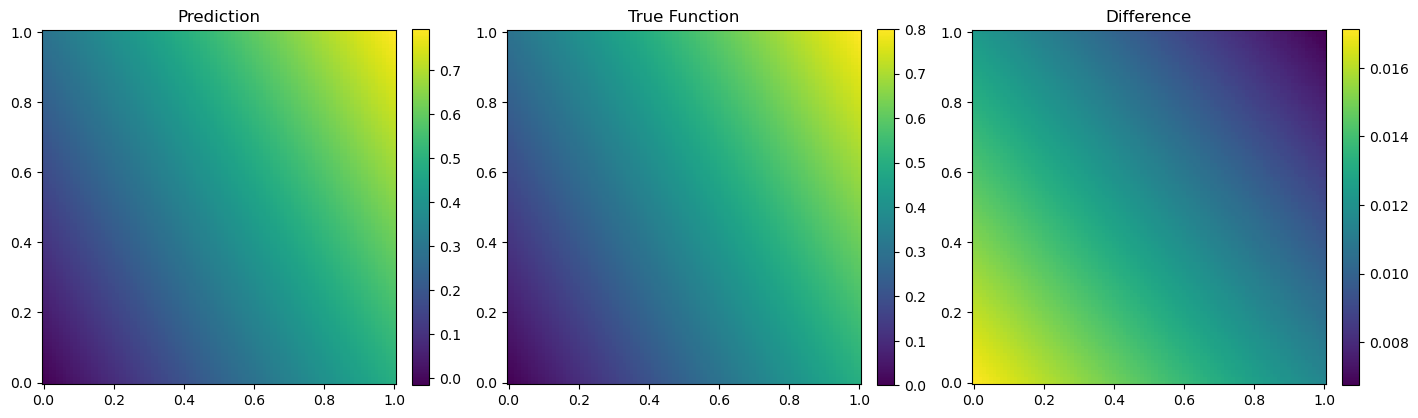

In [10]:
X = jnp.array(jnp.meshgrid(*grids))
Y = func(X[0],X[1])

f, ax = plt.subplots(1,3,figsize=(17,5))

m_plot = ax[0].pcolormesh(*grids,means_ppa.reshape(101,101))
ax[0].set_aspect('equal', 'box')
ax[0].set_title("Prediction")
t_plot = ax[1].pcolormesh(*grids,Y)
ax[1].set_aspect('equal', 'box')
ax[1].set_title("True Function")
diff_plot = ax[2].pcolormesh(*grids,Y - means_ppa.reshape(101,101))
ax[2].set_aspect('equal', 'box')
ax[2].set_title("Difference")
f.colorbar(m_plot, ax=ax[0], fraction=0.046, pad=0.04)
f.colorbar(t_plot, ax=ax[1], fraction=0.046, pad=0.04)
f.colorbar(diff_plot, ax=ax[2], fraction=0.046, pad=0.04)

In [11]:
def check_along_axis(means, stds, Y, grids):
    means_x1 = jnp.array([means[i,0] for i in range(means.shape[0])])
    means_x2 = jnp.array([means[0,i] for i in range(means.shape[1])])
    stds_x1 = jnp.array([stds[i,0] for i in range(stds.shape[0])])
    stds_x2 = jnp.array([stds[0,i] for i in range(stds.shape[1])])
    Y_x1 = jnp.array([Y[i,0] for i in range(Y.shape[0])])
    Y_x2 = jnp.array([Y[0,i] for i in range(Y.shape[1])])

    f,ax = plt.subplots(1,2)

    ax[0].plot(grids[0],means_x1)
    ax[0].fill_between(grids[0],means_x1-2*stds_x1,means_x1+2*stds_x1,alpha=0.5)
    ax[0].plot(grids[0],Y_x1)
    
    ax[1].plot(grids[1],means_x2)
    ax[1].fill_between(grids[1],means_x2-2*stds_x2,means_x2+2*stds_x2,alpha=0.5)
    ax[1].plot(grids[1],Y_x2)

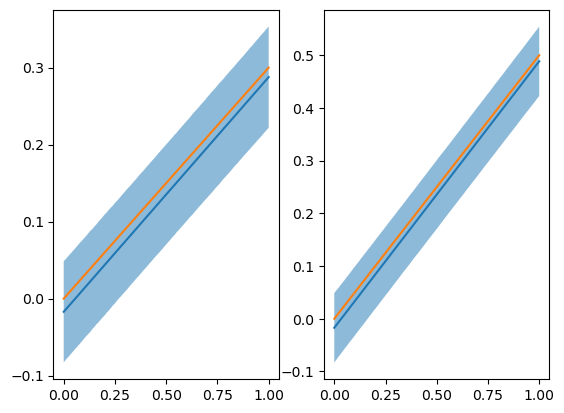

In [12]:
check_along_axis(means_ppa.reshape(101,101),stds_ppa.reshape(101,101),Y,grids)